In [1]:
import os, re
import numpy as np
import pandas as pd
import nltk

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer() 

mypath = "./Case Presentation 1"
files = os.listdir(mypath)
from nltk.stem import PorterStemmer

def txt_to_df(files):
    df = pd.DataFrame(columns=["content", "label"])
    for f in files:
        txtFile = open('./Case Presentation 1/'+f, 'r')
        tempTxt = txtFile.read().splitlines()
        flag = False
        content = ""
        
        for line in tempTxt:
            if line[-1:] == ":" : 
                flag = True
                continue
            if flag:
                content += (" " + line)
            
            content = re.sub(r'[^A-Za-z\s]',r' ',content)
            # Lowercase
            content = " ".join([w.lower() for w in content.split()])
            # Remove Stop
            content = " ".join([w for w in content.split() if w not in stop_words])
            # Stemming
            #st = PorterStemmer()
            #content = " ".join([st.stem(w) for w in content.split()])
            # 
            content = " ".join([lemmatizer.lemmatize(w, pos='v') for w in content.split()])
            #content = " ".join([lemmatizer.lemmatize(w, pos='n') for w in content.split()])
                
        if f[:3] == 'CUR':
            label = 'smoker'
        elif f[:3] == 'PAS':
            label = 'past_smoker'
        elif f[:3] == 'NON':
            label = 'non_smoker'
        else:
            label = 'unknown'
            
        df = df.append({
            "content": content,
            "label": label,

        }, ignore_index=True)
    return df

files = os.listdir("./Case Presentation 1/")
df = txt_to_df(files)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wendy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wendy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df_x = pd.DataFrame(df.iloc[:,0])
df_y = np.array(df.iloc[:,1])

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size=8, stratify=df_y)

In [4]:
# need survey how does TF-IDF work, not yet done
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

corpus_train = list(X_train["content"])
vectorizer = CountVectorizer(stop_words=stop_words, analyzer='word', max_features=50)
X = vectorizer.fit_transform(corpus_train) 

transformer = TfidfTransformer(smooth_idf=True)
tfidf = transformer.fit_transform(X)
r = pd.DataFrame(tfidf.toarray(),columns=vectorizer.get_feature_names())

corpus_val = list(X_val["content"])
X_val = vectorizer.transform(corpus_val) 
tfidf_val = transformer.transform(X_val)
r_val = pd.DataFrame(tfidf_val.toarray(),columns=vectorizer.get_feature_names())


In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

## SVM

In [6]:
from sklearn.metrics import confusion_matrix

Mean Accuracy:  0.57125


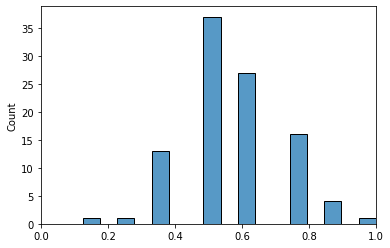

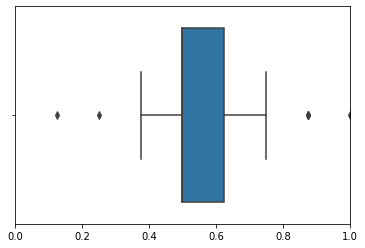

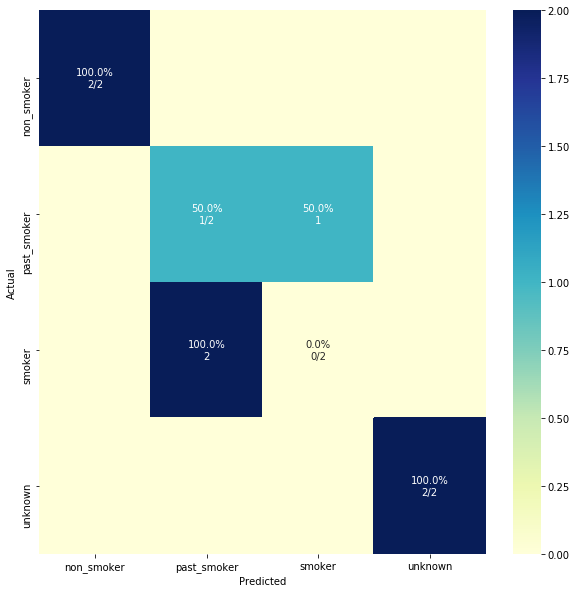

In [7]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

svm_score = []
best = 0
best_set = []
for i in range(100):
    np.random.seed(i)
    X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size=8, stratify=df_y)

    corpus_train = list(X_train["content"])
    vectorizer = CountVectorizer(stop_words=stop_words, analyzer='word', max_features=50)
    X = vectorizer.fit_transform(corpus_train) 

    transformer = TfidfTransformer(smooth_idf=True)
    tfidf = transformer.fit_transform(X)
    r = pd.DataFrame(tfidf.toarray(),columns=vectorizer.get_feature_names())

    corpus_val = list(X_val["content"])
    X_val = vectorizer.transform(corpus_val) 
    tfidf_val = transformer.transform(X_val)
    r_val = pd.DataFrame(tfidf_val.toarray(),columns=vectorizer.get_feature_names())

    svc = svm.SVC()

    grid = GridSearchCV(estimator=svc, 
                        param_grid={'C': [1, 5, 10, 50, 100], 
                                    'kernel': ('linear', 'rbf', 'poly', 'sigmoid')}, cv=4, scoring='accuracy', verbose=0)

    grid_result = grid.fit(r, y_train)

    predict = grid_result.best_estimator_.predict(r_val)
    if accuracy_score(predict, y_val) > best:
        best = accuracy_score(predict, y_val)
        best_set.append((predict, y_val)) 
        
    svm_score.append(accuracy_score(predict, y_val))
    
ax = sns.histplot(data=svm_score)
ax.set(xlim=(0, 1))
plt.figure()

bx = sns.boxplot(x=svm_score)
bx.set(xlim=(0, 1))



print('Mean Accuracy: ', sum(svm_score) / len(svm_score))
plot_cm(y_val, predict)

## Decision Tree

Mean Accuracy:  0.495


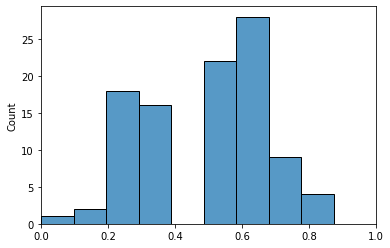

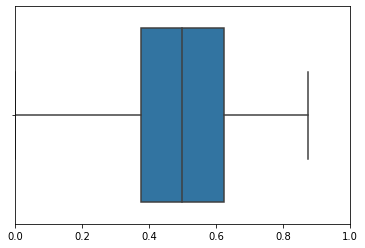

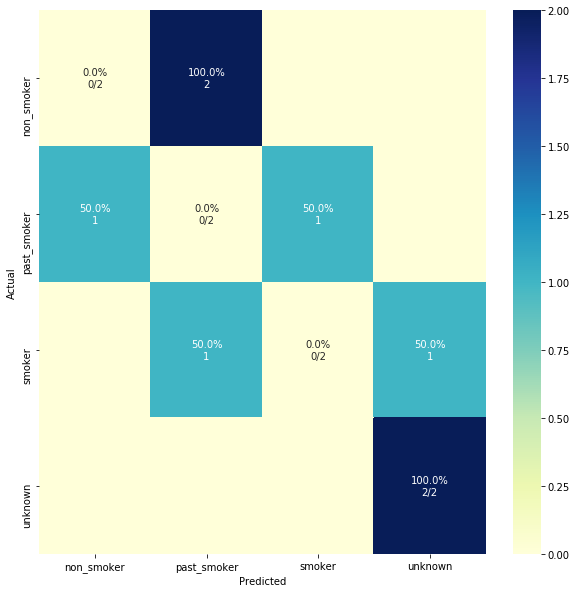

In [8]:
from sklearn import tree

tree_score = []
best = 0
best_set = []
for i in range(100):
    np.random.seed(i)
    X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size=8, stratify=df_y)

    corpus_train = list(X_train["content"])
    vectorizer = CountVectorizer(stop_words=stop_words, analyzer='word', max_features=50)
    X = vectorizer.fit_transform(corpus_train) 

    transformer = TfidfTransformer(smooth_idf=True)
    tfidf = transformer.fit_transform(X)
    r = pd.DataFrame(tfidf.toarray(),columns=vectorizer.get_feature_names())

    corpus_val = list(X_val["content"])
    X_val = vectorizer.transform(corpus_val) 
    tfidf_val = transformer.transform(X_val)
    r_val = pd.DataFrame(tfidf_val.toarray(),columns=vectorizer.get_feature_names())

    dt = tree.DecisionTreeClassifier

    grid = GridSearchCV(estimator=dt(),
                 param_grid={'criterion':['gini','entropy'],
                             'splitter':['best', 'random'],
                             'max_depth':[1,5,10,15,20,25,30]}, cv=4, scoring='accuracy', verbose=0)

    grid_result = grid.fit(r, y_train)

    predict = grid_result.best_estimator_.predict(r_val)
    if accuracy_score(predict, y_val) > best:
        best = accuracy_score(predict, y_val)
        best_set.append((predict, y_val)) 
        
    tree_score.append(accuracy_score(predict, y_val))
    
ax = sns.histplot(data=tree_score)
ax.set(xlim=(0, 1))
plt.figure()

bx = sns.boxplot(x=tree_score)
bx.set(xlim=(0, 1))

print('Mean Accuracy: ', sum(tree_score) / len(tree_score))
plot_cm(y_val, predict)

## Random Forest

Mean Accuracy:  0.5625


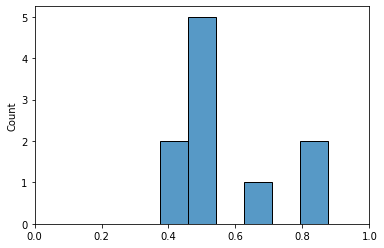

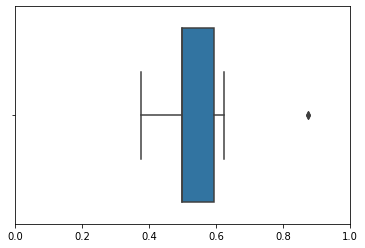

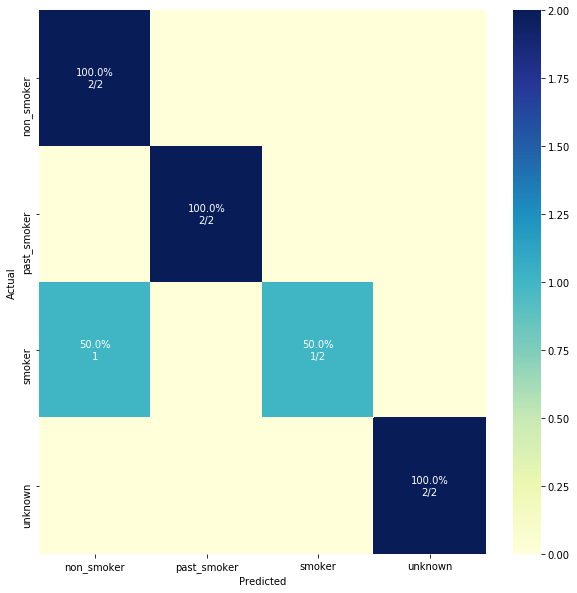

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf_score = []
best = 0
best_set = []
for i in range(10):
    np.random.seed(i)
    X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size=8, stratify=df_y)

    corpus_train = list(X_train["content"])
    vectorizer = CountVectorizer(stop_words=stop_words, analyzer='word', max_features=50)
    X = vectorizer.fit_transform(corpus_train) 

    transformer = TfidfTransformer(smooth_idf=True)
    tfidf = transformer.fit_transform(X)
    r = pd.DataFrame(tfidf.toarray(),columns=vectorizer.get_feature_names())

    corpus_val = list(X_val["content"])
    X_val = vectorizer.transform(corpus_val) 
    tfidf_val = transformer.transform(X_val)
    r_val = pd.DataFrame(tfidf_val.toarray(),columns=vectorizer.get_feature_names())

    forest = RandomForestClassifier

    grid = GridSearchCV(estimator=forest(),
                 param_grid={'n_estimators':[10,20,50,100],
                             'max_depth':[1,5,10,15,20,25,30],
                             'criterion':['gini', 'entropy']}, cv=4, scoring='accuracy', verbose=0)

    grid_result = grid.fit(r, y_train)

    predict = grid_result.best_estimator_.predict(r_val)
    if accuracy_score(predict, y_val) > best:
        best = accuracy_score(predict, y_val)
        best_set.append((predict, y_val)) 
        
    rf_score.append(accuracy_score(predict, y_val))
    
ax = sns.histplot(data=rf_score)
ax.set(xlim=(0, 1))
plt.figure()

bx = sns.boxplot(x=rf_score)
bx.set(xlim=(0, 1))

print('Mean Accuracy: ', sum(rf_score) / len(rf_score))
plot_cm(best_set[0][1], best_set[0][0])

## Logistic Regression

Mean Accuracy:  0.5325


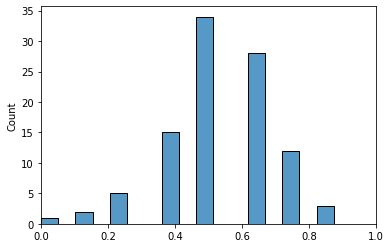

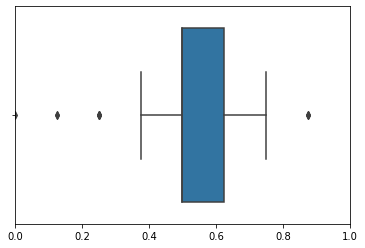

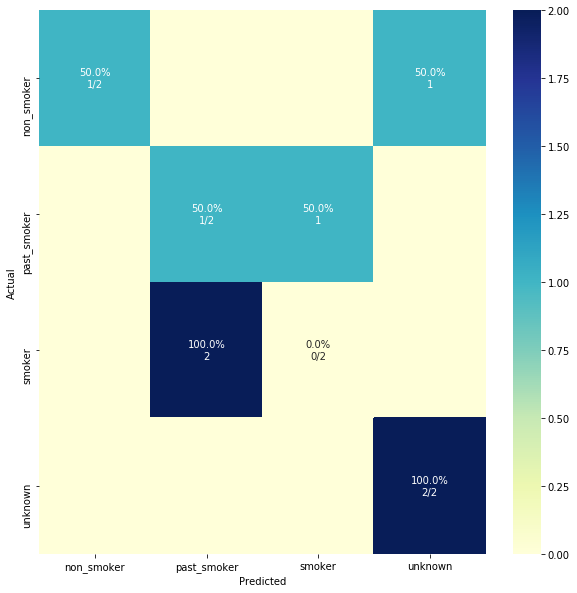

In [10]:
from sklearn.linear_model import LogisticRegression

lr_score = []
best = 0
best_set = []
for i in range(100):
    np.random.seed(i)
    X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size=8, stratify=df_y)

    corpus_train = list(X_train["content"])
    vectorizer = CountVectorizer(stop_words=stop_words, analyzer='word', max_features=50)
    X = vectorizer.fit_transform(corpus_train) 

    transformer = TfidfTransformer(smooth_idf=True)
    tfidf = transformer.fit_transform(X)
    r = pd.DataFrame(tfidf.toarray(),columns=vectorizer.get_feature_names())

    corpus_val = list(X_val["content"])
    X_val = vectorizer.transform(corpus_val) 
    tfidf_val = transformer.transform(X_val)
    r_val = pd.DataFrame(tfidf_val.toarray(),columns=vectorizer.get_feature_names())

    lr = LogisticRegression()

    grid = GridSearchCV(estimator=lr,
                 param_grid={'penalty':['l1', 'l2'],
                             'C':np.logspace(-3,3,7),
                             'solver':['liblinear']},cv=4, scoring='accuracy', verbose=0)

    grid_result = grid.fit(r, y_train)

    predict = grid_result.best_estimator_.predict(r_val)
    if accuracy_score(predict, y_val) > best:
        best = accuracy_score(predict, y_val)
        best_set.append((predict, y_val)) 
        
    lr_score.append(accuracy_score(predict, y_val))
    
ax = sns.histplot(data=lr_score)
ax.set(xlim=(0, 1))
plt.figure()

bx = sns.boxplot(x=lr_score)
bx.set(xlim=(0, 1))

print('Mean Accuracy: ', sum(lr_score) / len(lr_score))
plot_cm(y_val, predict)

## GradientBoostingClassifier

Mean Accuracy:  0.5


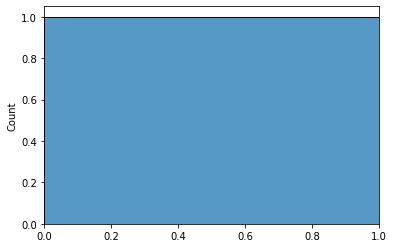

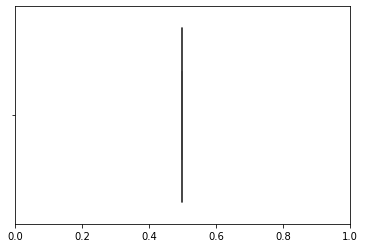

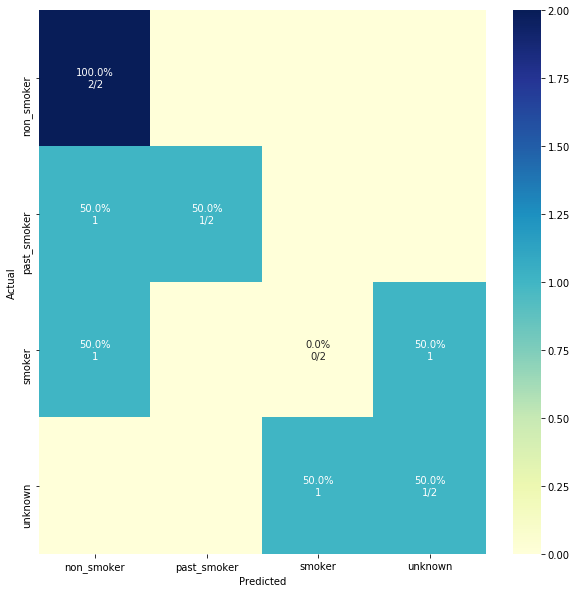

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

gdb_score = []
best = 0
best_set = []
for i in range(1):
    np.random.seed(i)
    X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size=8, stratify=df_y)

    corpus_train = list(X_train["content"])
    vectorizer = CountVectorizer(stop_words=stop_words, analyzer='word', max_features=50)
    X = vectorizer.fit_transform(corpus_train) 

    transformer = TfidfTransformer(smooth_idf=True)
    tfidf = transformer.fit_transform(X)
    r = pd.DataFrame(tfidf.toarray(),columns=vectorizer.get_feature_names())

    corpus_val = list(X_val["content"])
    X_val = vectorizer.transform(corpus_val) 
    tfidf_val = transformer.transform(X_val)
    r_val = pd.DataFrame(tfidf_val.toarray(),columns=vectorizer.get_feature_names())

    gdb = GradientBoostingClassifier()

    parameters = {
        "loss":["deviance"],
        "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
        "min_samples_split": np.linspace(0.1, 0.5, 5),
        "min_samples_leaf": np.linspace(0.1, 0.5, 5),
        "max_depth":[3,5,8],
        "max_features":["log2","sqrt"],
        "criterion": ["friedman_mse",  "mae"],
        "subsample":[0.5, 0.75, 0.9, 1.0],
        "n_estimators":[10]
        }

    grid = GridSearchCV(estimator=gdb,
                 param_grid=parameters, cv=4, scoring='accuracy', n_jobs=-1, verbose=0)

    grid_result = grid.fit(r, y_train)
    
    predict = grid_result.best_estimator_.predict(r_val)
    if accuracy_score(predict, y_val) > best:
        best = accuracy_score(predict, y_val)
        best_set.append((predict, y_val)) 
        
    gdb_score.append(accuracy_score(predict, y_val))

ax = sns.histplot(data=gdb_score)
ax.set(xlim=(0, 1))
plt.figure()

bx = sns.boxplot(x=gdb_score)
bx.set(xlim=(0, 1))

print('Mean Accuracy: ', sum(gdb_score) / len(gdb_score))
plot_cm(y_val, predict)

## MultinomialNB

Mean Accuracy:  0.60875


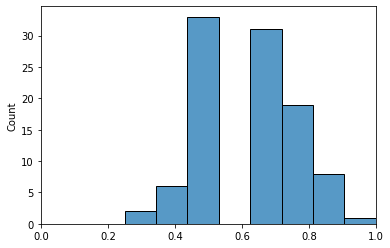

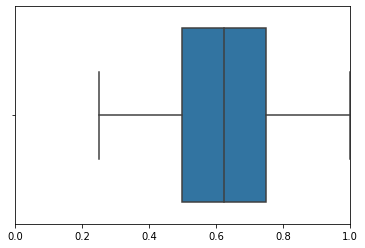

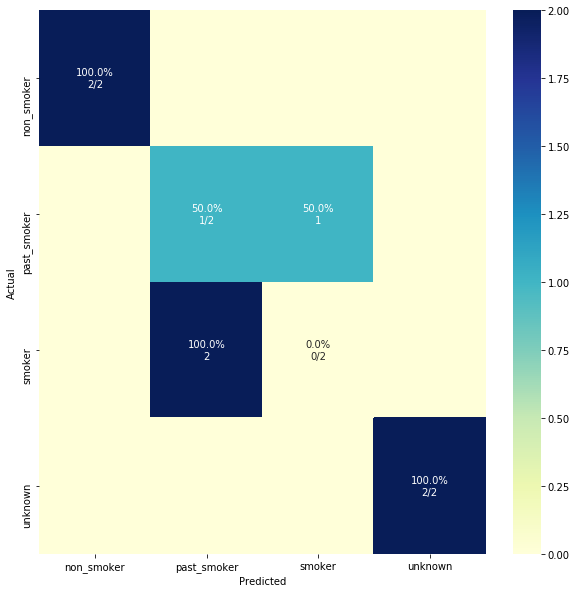

In [12]:
from sklearn.naive_bayes import MultinomialNB

nb_score = []
best = 0
best_set = []
for i in range(100):
    np.random.seed(i)
    X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size=8, stratify=df_y)

    corpus_train = list(X_train["content"])
    vectorizer = CountVectorizer(stop_words=stop_words, analyzer='word', max_features=50)
    X = vectorizer.fit_transform(corpus_train) 

    transformer = TfidfTransformer(smooth_idf=True)
    tfidf = transformer.fit_transform(X)
    r = pd.DataFrame(tfidf.toarray(),columns=vectorizer.get_feature_names())

    corpus_val = list(X_val["content"])
    X_val = vectorizer.transform(corpus_val) 
    tfidf_val = transformer.transform(X_val)
    r_val = pd.DataFrame(tfidf_val.toarray(),columns=vectorizer.get_feature_names())

    nb = MultinomialNB()

    grid = GridSearchCV(estimator=nb,
                 param_grid={'alpha':np.linspace(0.1, 1, 10)}, 
                        cv=4, scoring='accuracy', verbose=0)

    grid_result = grid.fit(r, y_train)
    predict = grid_result.best_estimator_.predict(r_val)
    if accuracy_score(predict, y_val) > best:
        best = accuracy_score(predict, y_val)
        best_set.append((predict, y_val)) 
        
    nb_score.append(accuracy_score(predict, y_val))

ax = sns.histplot(data=nb_score)
ax.set(xlim=(0, 1))
plt.figure()

bx = sns.boxplot(x=nb_score)
bx.set(xlim=(0, 1))

print('Mean Accuracy: ', sum(nb_score) / len(nb_score))
plot_cm(y_val, predict)

In [13]:
df_box = pd.DataFrame(svm_score, columns=['SVM'])
df_box['Decision Tree'] = tree_score
tmp = pd.DataFrame(rf_score, columns=['Random Forest'])
df_box['Random Forest'] = tmp
df_box['Logistic Regression'] = lr_score
tmp = pd.DataFrame(gdb_score, columns=['GradientBoostingClassifier'])
df_box['GradientBoostingClassifier'] = tmp
df_box['MultinomialNB'] = nb_score

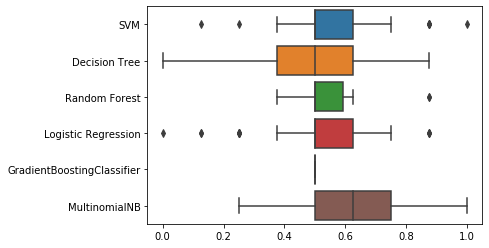

In [14]:
sns.boxplot(data=df_box, orient="h")